<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_AE/LSTM_AE_Cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 5.46 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Jul 15 12:13:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Cu'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 9.4MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
     |████████████████████████████████| 174kB 55.3MB/s 
     |████████████████████████████████| 143kB 53.9MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(LSTM(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(LSTM(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(LSTM(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: gy987oah
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_AE/sweeps/gy987oah


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: kjcml0c5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 25s 282ms/step - loss: 0.1867 - mean_squared_error: 0.1867 - mean_absolute_error: 0.3557 - val_loss: 0.0881 - val_mean_squared_error: 0.0881 - val_mean_absolute_error: 0.2724
Epoch 2/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1571 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1258
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1209 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1483
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.1042 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0938
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0116 - mean_squared_error: 0.0116

epoch,49
loss,0.00301
mean_squared_error,0.00301
mean_absolute_error,0.04295
val_loss,0.00604
val_mean_squared_error,0.00604
val_mean_absolute_error,0.05874
_runtime,42
_timestamp,1626351254
_step,49
best_val_loss,0.00604


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: esnd4tm4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 15s 461ms/step - loss: 0.3133 - mean_squared_error: 0.3133 - mean_absolute_error: 0.4917 - val_loss: 0.1903 - val_mean_squared_error: 0.1903 - val_mean_absolute_error: 0.3601
Epoch 2/100
8/8 [==============================] - 2s 227ms/step - loss: 0.1482 - mean_squared_error: 0.1482 - mean_absolute_error: 0.3087 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1040
Epoch 3/100
8/8 [==============================] - 2s 208ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0992 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0949
Epoch 4/100
8/8 [==============================] - 2s 211ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1086 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0934
Epoch 5/100
8/8 [==============================] - 2s 216ms/step - loss: 0.0120 - mean_squared_erro

epoch,29
loss,0.0069
mean_squared_error,0.0069
mean_absolute_error,0.06341
val_loss,0.01338
val_mean_squared_error,0.01338
val_mean_absolute_error,0.08476
_runtime,69
_timestamp,1626351331
_step,29
best_val_loss,0.0089


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: xwmpqjby with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 15s 269ms/step - loss: 41983.1322 - mean_squared_error: 41983.1322 - mean_absolute_error: 40.4300 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1344
Epoch 2/200
31/31 [==============================] - 7s 210ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1072 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0842
Epoch 3/200
31/31 [==============================] - 7s 214ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0971 - val_loss: 0.0350 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1434
Epoch 4/200
31/31 [==============================] - 7s 209ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1136 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0929
Epoch 5/200
31/31 [==============================] - 6s 204ms/step - loss: 0.0138 

epoch,78
loss,0.0023
mean_squared_error,0.0023
mean_absolute_error,0.03826
val_loss,0.00396
val_mean_squared_error,0.00396
val_mean_absolute_error,0.04777
_runtime,515
_timestamp,1626351853
_step,78
best_val_loss,0.00328


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▂▂▇▄▅▃▂▂▂▄▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▇█▂▂▇▄▅▃▂▂▂▄▂▂▂▂▁▂▂▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,▇▇▃▂█▅▅▅▂▃▃▅▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▃▁▁▁▁▁▁▂▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wdrrr6aj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 9s 126ms/step - loss: 0.1113 - mean_squared_error: 0.1113 - mean_absolute_error: 0.2370 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0981
Epoch 2/50
16/16 [==============================] - 0s 18ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0940 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0827
Epoch 3/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0654 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0913
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0818 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0782
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0075 - mean_squared_erro

epoch,49
loss,0.00201
mean_squared_error,0.00201
mean_absolute_error,0.03421
val_loss,0.0043
val_mean_squared_error,0.0043
val_mean_absolute_error,0.04932
_runtime,77
_timestamp,1626351938
_step,49
best_val_loss,0.00429


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁
val_loss,▆▄▅▄▆▆▄▃▃▃█▂▃▂▂▇▂▂▂▂▁▅▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▄▅▄▆▆▄▃▃▃█▂▃▂▂▇▂▂▂▂▁▅▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▅▅▄▇▆▄▃▃▄█▃▄▂▂█▂▃▂▂▂▆▂▂▂▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: njewme1m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 8s 74ms/step - loss: 0.0970 - mean_squared_error: 0.0970 - mean_absolute_error: 0.2295 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1112
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0592 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0810
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0540 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0752
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0477 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0711
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0038 - mean_squared_

epoch,99
loss,0.00113
mean_squared_error,0.00113
mean_absolute_error,0.02624
val_loss,0.00294
val_mean_squared_error,0.00294
val_mean_absolute_error,0.04165
_runtime,60
_timestamp,1626352008
_step,99
best_val_loss,0.00241


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▂▁▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▃▂▃▂▂▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: a5fwepan with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 9s 70ms/step - loss: 0.1570 - mean_squared_error: 0.1570 - mean_absolute_error: 0.3159 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0824
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0579 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0716
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0471 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0630
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0517 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0614
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0036 - mean_squared_

epoch,82
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.02737
val_loss,0.00269
val_mean_squared_error,0.00269
val_mean_absolute_error,0.0411
_runtime,53
_timestamp,1626352068
_step,82
best_val_loss,0.0024


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▅▄▃▃▃▃▃▃▄▂▂▂▃▂▂▂▂▂▂▂▁▂▁▃▂▂▁▂▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: aa2ipg73 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 15s 262ms/step - loss: 0.1503 - mean_squared_error: 0.1503 - mean_absolute_error: 0.2958 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0808
Epoch 2/100
31/31 [==============================] - 7s 216ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0873 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0822
Epoch 3/100
31/31 [==============================] - 7s 215ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0879 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1211
Epoch 4/100
31/31 [==============================] - 6s 210ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0848 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0946
Epoch 5/100
31/31 [==============================] - 7s 216ms/step - loss: 0.0108 - mean_sq

epoch,17
loss,0.00586
mean_squared_error,0.00586
mean_absolute_error,0.05828
val_loss,0.01072
val_mean_squared_error,0.01072
val_mean_absolute_error,0.07726
_runtime,130
_timestamp,1626352206
_step,17
best_val_loss,0.00795


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
val_loss,▂▂█▄▄▄▃▁▂▃▂▇▆▂▂▆▂▂
val_mean_squared_error,▂▂█▄▄▄▃▁▂▃▂▇▆▂▂▆▂▂
val_mean_absolute_error,▃▃█▄▅▄▃▁▂▂▂▇▇▂▃▆▂▂
_runtime,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: d99ho5kz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 11s 465ms/step - loss: 0.2492 - mean_squared_error: 0.2492 - mean_absolute_error: 0.4245 - val_loss: 0.0825 - val_mean_squared_error: 0.0825 - val_mean_absolute_error: 0.2146
Epoch 2/100
8/8 [==============================] - 2s 229ms/step - loss: 0.1055 - mean_squared_error: 0.1055 - mean_absolute_error: 0.2534 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - val_mean_absolute_error: 0.2188
Epoch 3/100
8/8 [==============================] - 2s 223ms/step - loss: 0.0721 - mean_squared_error: 0.0721 - mean_absolute_error: 0.2234 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1654
Epoch 4/100
8/8 [==============================] - 2s 215ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.1384 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1276
Epoch 5/100
8/8 [==============================] - 2s 222ms/step - loss: 0.0198 - mean_squared_erro

epoch,75
loss,0.00484
mean_squared_error,0.00484
mean_absolute_error,0.05094
val_loss,0.00532
val_mean_squared_error,0.00532
val_mean_absolute_error,0.05648
_runtime,147
_timestamp,1626352361
_step,75
best_val_loss,0.00504


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▂▂▂▁▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,██▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▄▂▃▄▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▄▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wzj8di79 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 12s 333ms/step - loss: 0.1883 - mean_squared_error: 0.1883 - mean_absolute_error: 0.3469 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1146
Epoch 2/50
16/16 [==============================] - 3s 217ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0817 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0750
Epoch 3/50
16/16 [==============================] - 3s 215ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0818 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0704
Epoch 4/50
16/16 [==============================] - 3s 215ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0944 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1404
Epoch 5/50
16/16 [==============================] - 3s 209ms/step - loss: 0.0137 - mean_squared

epoch,12
loss,0.00762
mean_squared_error,0.00762
mean_absolute_error,0.06906
val_loss,0.01497
val_mean_squared_error,0.01497
val_mean_absolute_error,0.10063
_runtime,57
_timestamp,1626352426
_step,12
best_val_loss,0.00829


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▁▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▂▂▁▁▁▂▁▁▁
val_loss,▄▁▁▆█▁▁▃▂▁▂▁▂
val_mean_squared_error,▄▁▁▆█▁▁▃▂▁▂▁▂
val_mean_absolute_error,▄▁▁▆█▂▁▄▃▂▃▂▃
_runtime,▁▂▂▃▃▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 6890uf4j with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 11s 467ms/step - loss: 1432.8644 - mean_squared_error: 1432.8644 - mean_absolute_error: 7.1117 - val_loss: 0.0753 - val_mean_squared_error: 0.0753 - val_mean_absolute_error: 0.2050
Epoch 2/200
8/8 [==============================] - 2s 219ms/step - loss: 0.0542 - mean_squared_error: 0.0542 - mean_absolute_error: 0.1921 - val_loss: 0.1109 - val_mean_squared_error: 0.1109 - val_mean_absolute_error: 0.2663
Epoch 3/200
8/8 [==============================] - 2s 230ms/step - loss: 0.0681 - mean_squared_error: 0.0681 - mean_absolute_error: 0.1996 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1513
Epoch 4/200
8/8 [==============================] - 2s 240ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - mean_absolute_error: 0.1439 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0840
Epoch 5/200
8/8 [==============================] - 2s 227ms/step - loss: 0.0107 - mean_square

epoch,34
loss,5.942732518631015e+29
mean_squared_error,5.942732518631015e+29
mean_absolute_error,636274977275904.0
val_loss,7.50345877406805e+28
val_mean_squared_error,7.503459246304699e+28
val_mean_absolute_error,272264838774784.0
_runtime,76
_timestamp,1626352511
_step,34
best_val_loss,0.00704


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▆█
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▆█
mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▇█
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▅▇█
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▅▇█
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▆▇█
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tx2m56wm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 9s 280ms/step - loss: 0.1718 - mean_squared_error: 0.1718 - mean_absolute_error: 0.3259 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1081
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0707 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0909
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0840 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0871
Epoch 4/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0746 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1093
Epoch 5/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0116 - mean_squared_error: 0.

epoch,12
loss,0.01168
mean_squared_error,0.01168
mean_absolute_error,0.08483
val_loss,0.0184
val_mean_squared_error,0.0184
val_mean_absolute_error,0.10713
_runtime,16
_timestamp,1626352536
_step,12
best_val_loss,0.01306


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▁▂▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▂▂▂▁▂▂▁▁▂
val_loss,▃▁▁▃▂▄▃█▃▄▃▃▃
val_mean_squared_error,▃▁▁▃▂▄▃█▃▄▃▃▃
val_mean_absolute_error,▃▁▁▃▃▄▃█▃▅▄▃▃
_runtime,▁▅▅▅▅▅▅██████
_timestamp,▁▅▅▅▅▅▅██████
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: n8itiop4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 166ms/step - loss: 0.1164 - mean_squared_error: 0.1164 - mean_absolute_error: 0.2501 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1074
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0732 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0979
Epoch 3/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0657 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0803
Epoch 4/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0631 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0919
Epoch 5/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0096 - mean_squared

epoch,99
loss,0.00162
mean_squared_error,0.00162
mean_absolute_error,0.03109
val_loss,0.00469
val_mean_squared_error,0.00469
val_mean_absolute_error,0.05334
_runtime,48
_timestamp,1626352597
_step,99
best_val_loss,0.00403


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▄▅▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▁▃▃▁▁▁▂▁▁▂▁▁▁▂▂▂▁▁▂▁
val_mean_squared_error,█▄▅▄▅▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▁▃▃▁▁▁▂▁▁▂▁▁▁▂▂▂▁▁▂▁
val_mean_absolute_error,█▅▅▅▆▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▃▄▂▁▁▂▁▁▂▁▂▁▂▃▂▁▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2309xem2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 15s 269ms/step - loss: 0.1824 - mean_squared_error: 0.1824 - mean_absolute_error: 0.3453 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1314
Epoch 2/50
31/31 [==============================] - 7s 209ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.1030 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0803
Epoch 3/50
31/31 [==============================] - 7s 211ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0643 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0724
Epoch 4/50
31/31 [==============================] - 6s 205ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0602 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0729
Epoch 5/50
31/31 [==============================] - 6s 208ms/step - loss: 0.0050 - mean_squared

epoch,48
loss,0.00221
mean_squared_error,0.00221
mean_absolute_error,0.03593
val_loss,0.00586
val_mean_squared_error,0.00586
val_mean_absolute_error,0.05758
_runtime,334
_timestamp,1626352940
_step,48
best_val_loss,0.00578


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▁▁▃▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▂▂▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▁▁▃▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▂▂▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▃▂▂▂▁▂▃▂▂▁▁▂▁▂▁▂▂▁▂▂▁▂▂▁▁▁▂▁▁▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p3gpy0oi with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 15s 247ms/step - loss: 0.1213 - mean_squared_error: 0.1213 - mean_absolute_error: 0.2590 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1014
Epoch 2/50
31/31 [==============================] - 7s 213ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1136 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1161
Epoch 3/50
31/31 [==============================] - 7s 214ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0823 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0985
Epoch 4/50
31/31 [==============================] - 7s 214ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0753 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0776
Epoch 5/50
31/31 [==============================] - 7s 224ms/step - loss: 0.0111 - mean_squared

epoch,49
loss,0.00333
mean_squared_error,0.00333
mean_absolute_error,0.04514
val_loss,0.00832
val_mean_squared_error,0.00832
val_mean_absolute_error,0.06935
_runtime,349
_timestamp,1626353355
_step,49
best_val_loss,0.00627


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▃▂▂▁█▄▂▂▁▂▂▂▂▂▃▂▁▂▁▁▂▂▁▁▂▁▁▂▁▁▁▁▂▂▁▁▂▁
val_mean_squared_error,▃▄▃▂▂▁█▄▂▂▁▂▂▂▂▂▃▂▁▂▁▁▂▂▁▁▂▁▁▂▁▁▁▁▂▂▁▁▂▁
val_mean_absolute_error,▄▅▃▂▃▂█▄▂▂▂▂▂▂▂▃▃▂▂▂▁▂▂▂▂▁▂▁▁▂▁▁▁▁▃▃▁▁▃▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l01554nz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 9s 256ms/step - loss: 0.2183 - mean_squared_error: 0.2183 - mean_absolute_error: 0.3698 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1334
Epoch 2/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1513 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1117
Epoch 3/200
8/8 [==============================] - 0s 26ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.1043 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1023
Epoch 4/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0781 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0924
Epoch 5/200
8/8 [==============================] - 0s 26ms/step - loss: 0.0099 - mean_squared_error: 0.

epoch,34
loss,0.0033
mean_squared_error,0.0033
mean_absolute_error,0.04595
val_loss,0.01029
val_mean_squared_error,0.01029
val_mean_absolute_error,0.08202
_runtime,21
_timestamp,1626353431
_step,34
best_val_loss,0.00571


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▁▁▃▁▂▂▂▁▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁
val_loss,█▅▅▄▃▇▂▂▅▃▂▃▃▂▃▂▃▃▂▁▁▁▂▁▁▃▁▁▁▃▂▁▁▁▃
val_mean_squared_error,█▅▅▄▃▇▂▂▅▃▂▃▃▂▃▂▃▃▂▁▁▁▂▁▁▃▁▁▁▃▂▁▁▁▃
val_mean_absolute_error,█▆▅▄▄▇▂▂▅▃▂▃▄▂▃▂▃▃▃▂▁▂▂▁▁▃▁▁▂▃▃▁▂▁▃
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7suclpks with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 15s 271ms/step - loss: 0.2071 - mean_squared_error: 0.2071 - mean_absolute_error: 0.3786 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1311
Epoch 2/50
31/31 [==============================] - 7s 215ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.1095 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0868
Epoch 3/50
31/31 [==============================] - 7s 216ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0695 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0818
Epoch 4/50
31/31 [==============================] - 7s 220ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0558 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0747
Epoch 5/50
31/31 [==============================] - 7s 216ms/step - loss: 0.0058 - mean_squared

epoch,35
loss,0.00207
mean_squared_error,0.00207
mean_absolute_error,0.03512
val_loss,0.00666
val_mean_squared_error,0.00666
val_mean_absolute_error,0.06104
_runtime,250
_timestamp,1626353692
_step,35
best_val_loss,0.00579


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▂▁▂▁▂▁▁▂▂▁▁▂▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▂▁▂▁▂▁▁▂▂▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: a0gbgck9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 9s 69ms/step - loss: 0.3508 - mean_squared_error: 0.3508 - mean_absolute_error: 0.3021 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0866
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0970 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0992
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0885 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1122
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0890 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0796
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0111 - mean_squared_

epoch,60
loss,0.00223
mean_squared_error,0.00223
mean_absolute_error,0.03678
val_loss,0.00296
val_mean_squared_error,0.00296
val_mean_absolute_error,0.04147
_runtime,43
_timestamp,1626353765
_step,60
best_val_loss,0.00295


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▆▆▇▅▃▅▃▆▃▂▂▂▂▃▂▃▁▂▂▁▂▂▂▂▁▂▁▂▂▁▁▁▁▂▁▁▁
val_mean_squared_error,▆█▅▆▆▇▅▃▅▃▆▃▂▂▂▂▃▂▃▁▂▂▁▂▂▂▂▁▂▁▂▂▁▁▁▁▂▁▁▁
val_mean_absolute_error,▆█▆▆▇█▅▃▆▃▆▄▂▂▂▃▃▂▃▂▂▃▂▂▂▂▃▂▂▁▂▂▂▁▂▁▂▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: e8uno49f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 9s 126ms/step - loss: 1.5201 - mean_squared_error: 1.5201 - mean_absolute_error: 0.6625 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1419
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1500 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0862
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1095 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1488
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1552 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1218
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0287 - mean_squared_erro

epoch,27
loss,0.00657
mean_squared_error,0.00657
mean_absolute_error,0.06178
val_loss,0.01313
val_mean_squared_error,0.01313
val_mean_absolute_error,0.09888
_runtime,21
_timestamp,1626353797
_step,27
best_val_loss,0.0045


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▄▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▂▄▂▆█▂▆▃▂▂▁▁▁▁▄▂▁▁▂▂▁▁▂▂▁▂▂
val_mean_squared_error,▄▂▄▂▆█▂▆▃▂▂▁▁▁▁▄▂▁▁▂▂▁▁▂▂▁▂▂
val_mean_absolute_error,▅▂▅▄██▄█▄▂▃▂▂▁▂▅▂▁▁▃▃▁▁▃▃▂▃▃
_runtime,▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: h6kyfxjb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 8s 257ms/step - loss: 0.1442 - mean_squared_error: 0.1442 - mean_absolute_error: 0.2946 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1029
Epoch 2/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1096 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1041
Epoch 3/200
8/8 [==============================] - 0s 20ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0999 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0857
Epoch 4/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0828 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0957
Epoch 5/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0107 - mean_squared_error: 0.

epoch,48
loss,0.00612
mean_squared_error,0.00612
mean_absolute_error,0.05874
val_loss,0.00708
val_mean_squared_error,0.00708
val_mean_absolute_error,0.06565
_runtime,22
_timestamp,1626353829
_step,48
best_val_loss,0.00701


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▃▂▂▃▁▂▂▂▂▁▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▃▄▅▅▃█▂▃▃▂▂▄▃▃▂▂▃▃▂▄▁▃▁▁▁▂▃▁▂▁▂▁▁▂▂▁▁▁
val_mean_squared_error,▄▄▃▄▅▅▃█▂▃▃▂▂▄▃▃▂▂▃▃▂▄▁▃▁▁▁▂▃▁▂▁▂▁▁▂▂▁▁▁
val_mean_absolute_error,▅▅▃▄▆▆▃█▃▃▃▃▂▄▃▄▂▃▃▃▂▅▁▃▁▁▁▂▃▂▃▁▃▂▁▂▂▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 25bn5l45 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 12s 326ms/step - loss: 0.1611 - mean_squared_error: 0.1611 - mean_absolute_error: 0.3075 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1239
Epoch 2/100
16/16 [==============================] - 3s 214ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0980 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0749
Epoch 3/100
16/16 [==============================] - 3s 207ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0767 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1249
Epoch 4/100
16/16 [==============================] - 3s 206ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0769 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0715
Epoch 5/100
16/16 [==============================] - 3s 192ms/step - loss: 0.0086 - mean_sq

epoch,63
loss,0.00283
mean_squared_error,0.00283
mean_absolute_error,0.04041
val_loss,0.0086
val_mean_squared_error,0.0086
val_mean_absolute_error,0.06964
_runtime,233
_timestamp,1626354082
_step,63
best_val_loss,0.00555


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▅▃▂▄▂▂▂▂▅▅▂▂▂▂▂▁▂▄▄▁▁▁▂▁▁▁▁▁▁▂▁▁▂▃▂▄▂
val_mean_squared_error,█▃▂▅▃▂▄▂▂▂▂▅▅▂▂▂▂▂▁▂▄▄▁▁▁▂▁▁▁▁▁▁▂▁▁▂▃▂▄▂
val_mean_absolute_error,█▃▂▅▃▂▄▂▂▂▂▅▅▂▂▂▂▂▁▂▄▄▁▁▁▂▁▂▂▁▁▁▂▁▁▂▄▃▄▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wvi1bw03 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 13s 342ms/step - loss: 0.2433 - mean_squared_error: 0.2433 - mean_absolute_error: 0.4136 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1079
Epoch 2/200
16/16 [==============================] - 3s 212ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1019 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0948
Epoch 3/200
16/16 [==============================] - 4s 223ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0914 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0839
Epoch 4/200
16/16 [==============================] - 4s 220ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0734 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0831
Epoch 5/200
16/16 [==============================] - 4s 226ms/step - loss: 0.0082 - mean_sq

epoch,41
loss,0.00369
mean_squared_error,0.00369
mean_absolute_error,0.04669
val_loss,0.01658
val_mean_squared_error,0.01658
val_mean_absolute_error,0.09774
_runtime,166
_timestamp,1626354259
_step,41
best_val_loss,0.00753


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂▂▄█▁▁▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▂▂▁▁▃▁▁▁▁▂▁▁▂▁▃
val_mean_squared_error,▃▂▂▂▄█▁▁▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▂▂▁▁▃▁▁▁▁▂▁▁▂▁▃
val_mean_absolute_error,▄▃▂▂▄█▂▂▂▃▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▂▂▁▂▃▁▁▁▁▂▁▁▂▁▃
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: o3eeu450 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 12s 337ms/step - loss: 0.2623 - mean_squared_error: 0.2623 - mean_absolute_error: 0.4344 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1037
Epoch 2/50
16/16 [==============================] - 4s 225ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1070 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1339
Epoch 3/50
16/16 [==============================] - 4s 222ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0890 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1196
Epoch 4/50
16/16 [==============================] - 4s 221ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0827 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0964
Epoch 5/50
16/16 [==============================] - 3s 199ms/step - loss: 0.0082 - mean_squared

epoch,22
loss,0.00412
mean_squared_error,0.00412
mean_absolute_error,0.04868
val_loss,0.01111
val_mean_squared_error,0.01111
val_mean_absolute_error,0.08006
_runtime,95
_timestamp,1626354411
_step,22
best_val_loss,0.01045


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▇▅▃▅▂▅▂▇▃█▄▁▃▃▁▆▃▃▄▆▃▁
val_mean_squared_error,▃▇▅▃▅▂▅▂▇▃█▄▁▃▃▁▆▃▃▄▆▃▁
val_mean_absolute_error,▄▇▆▃▆▂▅▃▇▃█▄▁▃▃▁▆▃▄▄▆▃▁
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: kfcgv8ov with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 9s 121ms/step - loss: 1.5571 - mean_squared_error: 1.5571 - mean_absolute_error: 0.6805 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1043
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1166 - val_loss: 0.0472 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1978
Epoch 3/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1550 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0932
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1517 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0846
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0306 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,29
loss,0.00619
mean_squared_error,0.00619
mean_absolute_error,0.06228
val_loss,0.01316
val_mean_squared_error,0.01316
val_mean_absolute_error,0.09031
_runtime,23
_timestamp,1626354500
_step,29
best_val_loss,0.00424


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▃▄▃▂▂▂▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁
val_loss,▃▇▂▂▄▄▄█▃▂▃▄▂▁▁▅▁▁▁▁▁▂▂▃▂▁▁▁▂▂
val_mean_squared_error,▃▇▂▂▄▄▄█▃▂▃▄▂▁▁▅▁▁▁▁▁▂▂▃▂▁▁▁▂▂
val_mean_absolute_error,▄█▃▃▄▅▄█▅▂▃▅▃▁▁▆▁▂▁▁▁▂▂▄▂▁▂▂▃▃
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: wrtk6h34 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 9s 129ms/step - loss: 0.1102 - mean_squared_error: 0.1102 - mean_absolute_error: 0.2410 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1041
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0840 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0798
Epoch 3/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0775 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0857
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0771 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0768
Epoch 5/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0044 - mean_squared

epoch,99
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.02987
val_loss,0.00283
val_mean_squared_error,0.00283
val_mean_absolute_error,0.04062
_runtime,50
_timestamp,1626354568
_step,99
best_val_loss,0.00283


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄█▃▃▃▂▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁
val_mean_squared_error,█▅▄█▃▃▃▂▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁
val_mean_absolute_error,▇▅▄█▄▃▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▃▂▂▂▃▁▃▁▁▂▂▁▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4a05wkb0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 8s 246ms/step - loss: 0.4592 - mean_squared_error: 0.4592 - mean_absolute_error: 0.4618 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0983
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0776 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0860
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0692 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0804
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0771 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1028
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.0096 - mean_squared_error: 0.0096 

epoch,12
loss,0.01516
mean_squared_error,0.01516
mean_absolute_error,0.09868
val_loss,0.02353
val_mean_squared_error,0.02353
val_mean_absolute_error,0.12718
_runtime,16
_timestamp,1626354600
_step,12
best_val_loss,0.01079


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▁▂▂▂▂▂▂▁▂
val_loss,▃▂▁▄▄▃▇▄█▄█▅▇
val_mean_squared_error,▃▂▁▄▄▃▇▄█▄█▅▇
val_mean_absolute_error,▃▂▁▄▄▃▇▄█▄█▆▇
_runtime,▁▁▁▅▅▅▅▅▅████
_timestamp,▁▁▁▅▅▅▅▅▅████
_step,▁▂▂▃▃▄▅▅▆▆▇▇█


wandb: Agent Starting Run: pepym1pw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 11s 479ms/step - loss: 0.2553 - mean_squared_error: 0.2553 - mean_absolute_error: 0.4299 - val_loss: 0.0580 - val_mean_squared_error: 0.0580 - val_mean_absolute_error: 0.1804
Epoch 2/50
8/8 [==============================] - 2s 225ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1478 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1035
Epoch 3/50
8/8 [==============================] - 2s 218ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0876 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0841
Epoch 4/50
8/8 [==============================] - 2s 234ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0816 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0781
Epoch 5/50
8/8 [==============================] - 2s 231ms/step - loss: 0.0071 - mean_squared_error: 0.

epoch,47
loss,0.00304
mean_squared_error,0.00304
mean_absolute_error,0.0422
val_loss,0.00703
val_mean_squared_error,0.00703
val_mean_absolute_error,0.06483
_runtime,104
_timestamp,1626354720
_step,47
best_val_loss,0.00698


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▄▂▂▁▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▄▂▂▁▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▅▂▂▁▁▁▁▂▂▁▁▂▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4s3cvd7c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 9s 71ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - mean_absolute_error: 0.1868 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0901
Epoch 2/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0848 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0850
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0881 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1330
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0802 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1178
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0111 - mean_squared_

epoch,95
loss,0.00166
mean_squared_error,0.00166
mean_absolute_error,0.03202
val_loss,0.00347
val_mean_squared_error,0.00347
val_mean_absolute_error,0.04613
_runtime,64
_timestamp,1626354846
_step,95
best_val_loss,0.00268


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▂▂▂▅▂▂▂▃▂▂▂▂▁▁▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▃▂▂▂▅▂▂▂▃▂▂▂▂▁▁▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▃▃▃▃▆▂▃▂▄▃▂▂▂▂▂▂▁▃▃▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: p2jprs65 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 9s 128ms/step - loss: 0.1750 - mean_squared_error: 0.1750 - mean_absolute_error: 0.3132 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0979
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0952 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0721
Epoch 3/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0563 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0654
Epoch 4/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0451 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0631
Epoch 5/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0033 - mean_squared

epoch,110
loss,0.00169
mean_squared_error,0.00169
mean_absolute_error,0.03219
val_loss,0.00335
val_mean_squared_error,0.00335
val_mean_absolute_error,0.04638
_runtime,50
_timestamp,1626354935
_step,110
best_val_loss,0.00245


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▄▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9haw09qy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 13s 389ms/step - loss: 303.1121 - mean_squared_error: 303.1121 - mean_absolute_error: 2.2310 - val_loss: 0.0716 - val_mean_squared_error: 0.0716 - val_mean_absolute_error: 0.2070
Epoch 2/50
16/16 [==============================] - 4s 221ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - mean_absolute_error: 0.1795 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1161
Epoch 3/50
16/16 [==============================] - 4s 233ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1003 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0984
Epoch 4/50
16/16 [==============================] - 4s 221ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0934 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0994
Epoch 5/50
16/16 [==============================] - 3s 212ms/step - loss: 0.0128 - mean_squ

epoch,14
loss,0.01546
mean_squared_error,0.01546
mean_absolute_error,0.09711
val_loss,0.03407
val_mean_squared_error,0.03407
val_mean_absolute_error,0.14104
_runtime,68
_timestamp,1626355014
_step,14
best_val_loss,0.01046


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▂▁▁▂▁▁▁▁▁▄
val_mean_squared_error,█▂▂▂▁▂▁▁▂▁▁▁▁▁▄
val_mean_absolute_error,█▃▂▂▁▂▁▁▂▁▂▂▂▁▄
_runtime,▁▁▂▃▃▄▄▄▅▅▆▆▇▇█
_timestamp,▁▁▂▃▃▄▄▄▅▅▆▆▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: kuytf66g with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 12s 341ms/step - loss: 0.1708 - mean_squared_error: 0.1708 - mean_absolute_error: 0.3372 - val_loss: 0.0545 - val_mean_squared_error: 0.0545 - val_mean_absolute_error: 0.2119
Epoch 2/50
16/16 [==============================] - 4s 220ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1671 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0936
Epoch 3/50
16/16 [==============================] - 4s 226ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0894 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0868
Epoch 4/50
16/16 [==============================] - 4s 219ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0704 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0842
Epoch 5/50
16/16 [==============================] - 4s 238ms/step - loss: 0.0064 - mean_squared

epoch,30
loss,0.00242
mean_squared_error,0.00242
mean_absolute_error,0.03888
val_loss,0.00861
val_mean_squared_error,0.00861
val_mean_absolute_error,0.07114
_runtime,120
_timestamp,1626355173
_step,30
best_val_loss,0.00716


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 0h0sxwlv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 12s 381ms/step - loss: 0.1680 - mean_squared_error: 0.1680 - mean_absolute_error: 0.3146 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0985
Epoch 2/100
16/16 [==============================] - 4s 233ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0893 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0814
Epoch 3/100
16/16 [==============================] - 3s 212ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0740 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1147
Epoch 4/100
16/16 [==============================] - 3s 199ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0908 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1001
Epoch 5/100
16/16 [==============================] - 3s 206ms/step - loss: 0.0123 - mean_sq

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'dropout': 0.2,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(LSTM(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(LSTM(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(LSTM(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  247937


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 6s 10ms/step - loss: 0.9123
Epoch 2/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0060
Epoch 3/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0041
Epoch 4/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0036
Epoch 5/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 6/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 7/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 8/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0029
Epoch 9/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 10/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 11/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 12/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 13/100
39/39 [=====

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

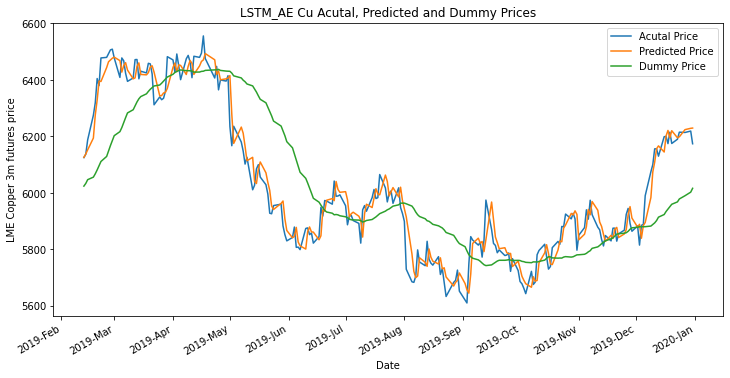

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

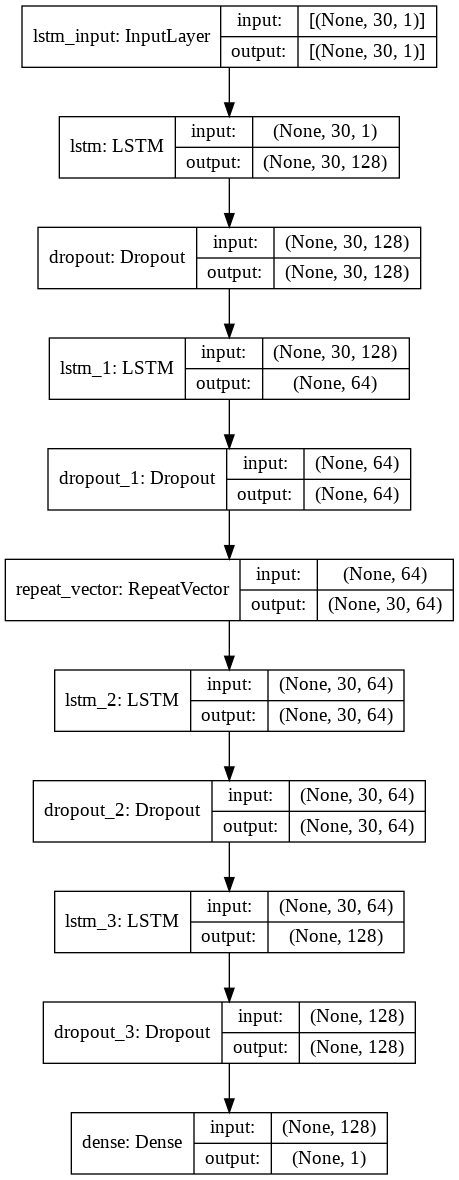

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0030002558282964677
RMSE:  0.05477459108287772
MAE:  0.04277103877495669
Dummy MSE:  0.02889885289047612
Dummy RMSE:  0.16999662611497945
Dummy MAE:  0.13217330779902475


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Cu/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_AE_Cu/assets
